# Lab: UAV-assisted wireless localization

_Fraida Fund_

* **Net ID**:LZ3546
* **Name**:Luxi Zhang


You've been asked to contribute your machine learning expertise to a crucial and potentially life-saving mission.

A pair of hikers has gone missing in a national park, and they are believed to be critically injured. Fortunately, they have activated a wireless locator beacon, and it transmits a constant wireless signal from their location. Unfortunately, their beacon was not able to get a satellite fix, so their GPS position is not known.

To rescue the injured hikers, therefore, their location must be estimated using the signal strength of the wireless signal from the beacon: when a radio receiver is close to the beacon, the signal strength will be high. When a radio receiver is far from the beacon, the signal strength will be lower.  (The relationship is noisy, however; the wireless signal also fluctuates over time, even with a constant distance.)

You are going to fly an unmanned aerial vehicle (UAV) with a radio receiver around the area where they were last seen, and use the received wireless signal strength to fit a machine learning model that will estimate the hikers' position. Then, you'll relay this information to rescuers, who will try to reach that position by land. (Unfortunately, due to dense tree cover, the UAV will not be able to visually confirm their position.)

There is a complication, though - the UAV has a limited battery life, and therefore, limited flight time. You'll have to get an accurate estimate of the hikers' position in a very short time!



---

#### Objectives

In this experiment, you will:

* observe how the RBF kernel is used in a Gaussian Process Regression
* observe how the Gaussian Process Regression approximates the true function
* observe how Bayesian Optimization is used to decide which data point to acquire next.


---

#### Citations

This experiment uses the Bayesian Optimization implementation of

>  Fernando Nogueira, "Bayesian Optimization: Open source constrained global optimization tool for Python," 2014. Available: https://github.com/fmfn/BayesianOptimization


The figures in the background section are from:

> Wang, Jie. "An intuitive tutorial to Gaussian processes regression." Computing in Science & Engineering (2023). https://arxiv.org/abs/2009.10862

with contributions by Yufei Zhen.


In [1]:
!pip install bayesian-optimization==2.0.0 numpy==1.26.4 scikit_learn==1.5.2

After running the cell above, use Runtime > Restart Session from the Colab menu. Then, continue with the next cell.

In [2]:
import numpy as np
import pickle

from bayes_opt import BayesianOptimization, acquisition
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF

import geopy.distance

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from ipywidgets import interact, fixed, widgets
from mpl_toolkits import mplot3d
from IPython.core.interactiveshell import InteractiveShell
plt.rcParams['axes.formatter.useoffset'] = False


## Framing the problem

We are going to estimate the hikers' position based on the premise that the received signal strength is highest when the UAV is at the same latitude and longitude as the hikers.

We will frame our machine learning problem as follows:

* features $X$: latitude, longitude
* target variable $y$: received signal strength

In other words, given a coordinate (latitude and longitude) we want to predict the received signal strength at that location.

However, we don't really care if our model is bad at predicting the signal strength in places where it is low! Our *true* goal is to predict where the target variable will be highest. We will decide how "good" our model is by computing the mean squared error of the position estimate: the distance between the true location of the hikers, and the coordinate that our model predicts has the highest received signal strength.

#### Gaussian Process


A Gaussian process is a stochastic process (a collection of random variables), where

* any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable $f(\mathbf{x})$
* the joint distribution of a finite number of these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ is itself Gaussian, i.e. has a multivariate normal distribution:

$$ p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K})$$






In the expression above,

* $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ are the random variables,
* $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_N))$ where $m$ is a mean function,
* and $K_{ij} = k(\mathbf{x}_i,\mathbf{x}_j)$ $k$ is a *kernel function* or *covariance function*.


Informally, you may think of a Gaussian process as a distribution over functions, whose shape (for example, the smoothness) is defined by the kernel function.

If two points $\mathbf{x}_i$ and $\mathbf{x}_j$ are considered similar by the kernel, then we expect the function at these points, $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$, to also have similar values.

#### Gaussian Process Regression

Given that a Gaussian process is a distribution over functions, we can think about the mean of the Gaussian process as the mean over all of these functions.


For example, suppose we will use the kernel function

$$k(x_i,x_j)  = \exp\left(- \frac{d(x_i, x_j)^2}{2l^2} \right)$$

where $d(.)$ is the Euclidean distance and $l$ is a length scale hyperparameter.




In [3]:
def rbf_kernel(a, b, l=0.1):
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    # note: uses the fact that ||a-b||^2 = ||a||^2 + ||b||^2 - 2 * a^T * b
    return np.exp((-1/(2*l)) * sqdist)

If we would sample *one* function from the Gaussian process defined by this kernel (and with zero mean), it might look like this:

In [4]:
@interact(m = widgets.IntSlider(min=1, max=100, step=1, value=1, description="Functions:"),
          l = widgets.FloatLogSlider(value=0.1,  base=10,  min=-2, max=2, step=0.1, description='Kernel l:'),
          show_mean = widgets.Checkbox(value=False,  description='Show mean and variance' ),
          show_samp = widgets.Checkbox(value=True,  description='Show sampled functions' )
          )
def sample_prior(m = 1, l=0.1, show_mean = False, show_samp = True):
  n = 50 #   # n points in the range of (0, 1)

  # compute means and kernel
  mean = np.zeros(n)
  Xshow = np.linspace(0, 1, n).reshape(-1,1)
  K_ = rbf_kernel(Xshow, Xshow, l=l)
  # now sample from multivariate normal m times
  f_prior = np.random.multivariate_normal(mean, K_, 1000).T

  plt.figure(figsize=(10, 5))

  # show the mean and standard deviation across all the sampled functions
  if show_mean:
    mean_samples = f_prior.mean(axis=1)
    var_samples  = f_prior.var(axis=1)
    plt.plot(Xshow, mean_samples, c='black')
    plt.gca().fill_between(Xshow.flat, mean_samples+var_samples, mean_samples-var_samples,
                        color ='grey', alpha=0.2 )

  # show the first m samples from the prior distribution
  if show_samp:
    for i in range(m):
        plt.plot(Xshow, f_prior[:,i], '-o', c='tab:blue',  alpha=0.3 )

  plt.ylim(-3,3)
  plt.xlim(0,1)
  plt.xlabel("x")
  plt.show()


interactive(children=(IntSlider(value=1, description='Functions:', min=1), FloatLogSlider(value=0.1, descripti…

You can change the value of the kernel hyperparameter $l$ using the slider, to see the effect. For the RBF kernel, the length scale hyperparameter determines how fast the function varies.

Now suppose we were to sample *many* functions from the Gaussian Process. Try it - move the "Functions" slider all the way to the right, to show a large number of Gaussian random variables sampled from the Gaussian process.

The mean of the Gaussian process is the expectation across all of the (infinite) functions. Check the "Show mean and variance" box to see it the sample mean and variance across 1000 sampled functions from the Gaussian process.

This is the idea of the *prior* in our Gaussian process regression. Initially, our model considers each of these functions to be equally probable, and its prediction is the expectation across all of them.

However, as we sample points from the "true function", we no longer consider every function in the Gaussian process to be equally probable.

For example, if we observe a data point that tells us that the value of the "true function" at $x = 0.5$,

$$t(0.5) = 1$$

we would note that only some of the functions in the Gaussian process are consistent with that observation. This is the idea of the *posterior* -  our current belief based on the existing observations.

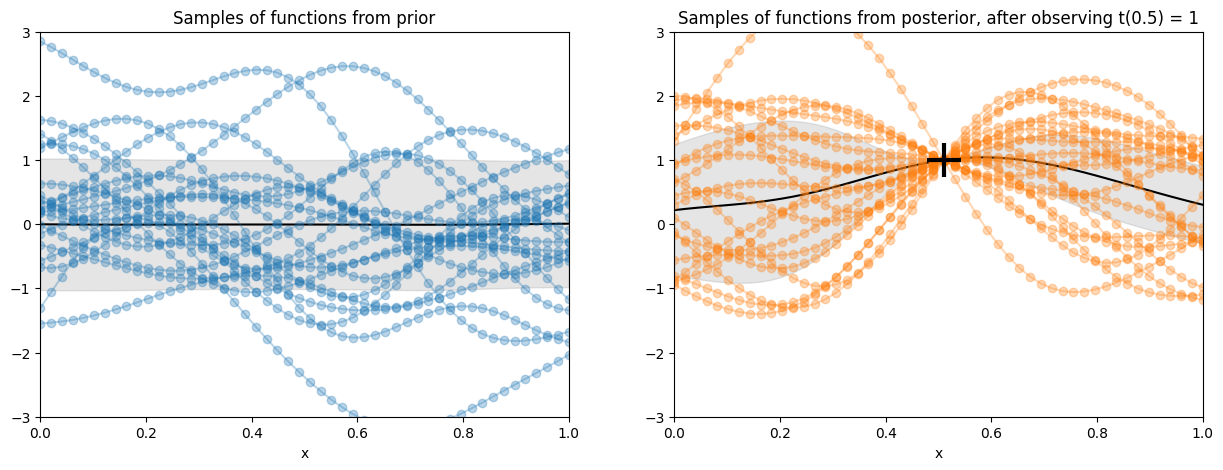

In [5]:
plt.figure(figsize=(15, 5))

n = 50 #   # n points in the range of (0, 1)
m = 20

# compute means and kernel
mean = np.zeros(n)
Xshow = np.linspace(0, 1, n).reshape(-1,1)
K_ = rbf_kernel(Xshow, Xshow, l=0.05)

# samples from prior
f_prior = np.random.multivariate_normal(mean, K_, 10000).T
mean_prior = f_prior.mean(axis=1)
var_prior  = f_prior.var(axis=1)

# now from posterior, given that t(0.5) = true_val
true_val = 1
samples_mid = f_prior[int(n/2), :]
post = np.argwhere((samples_mid >=  true_val-1e-2) & (samples_mid <= true_val+1e-2))
f_post = f_prior[:,post[:,0]]
mean_post = f_post.mean(axis=1)
var_post =  f_post.var(axis=1)

plt.subplot(1, 2, 1)
plt.plot(Xshow, mean_prior, c='black')
plt.gca().fill_between(Xshow.flat, mean_prior+var_prior, mean_prior-var_prior,
                    color ='grey', alpha=0.2 )
for i in range(m):
  plt.plot(Xshow, f_prior[:,i], '-o', c='tab:blue',  alpha=0.3 );
plt.ylim(-3,3);
plt.xlim(0,1);
plt.xlabel("x");
plt.title("Samples of functions from prior");


plt.subplot(1, 2, 2)
plt.plot(Xshow, mean_post, c='black')
plt.gca().fill_between(Xshow.flat, mean_post+var_post, mean_post-var_post,
                    color ='grey', alpha=0.2 )
for i in range(min(m, post.shape[0])):
  plt.plot(Xshow, f_post[:,i], '-o', c='tab:orange',  alpha=0.3 );
plt.plot(Xshow[int(n/2)], true_val, 'k+', markersize=25, markeredgewidth=3);

plt.ylim(-3,3);
plt.xlim(0,1);
plt.xlabel("x");
plt.title("Samples of functions from posterior, after observing t(0.5) = 1");



Furthermore, given this observation, the mean (*across the posterior*) has changed from the constant mean across the prior - now our model will predict that the value at $x = 0.5$ should be 1. (Note that because of the kernel function, the "mean" line - which is the prediction of our Gaussian process regression model - is smooth.)

Meanwhile, in the parts of the space that we have not sampled yet, the kernel function tells us what values of the function are likely, given the points we *have* sampled and the covariance function.


As we sample more points, our "mean" function will start to take on a shape that fits the data well, thus (hopefully) modeling the true function.


And, the standard deviation across the functions *in our posterior* is no longer constant for all values of $x$:

* Near our observation at $x = 0.5$, we have very little uncertainty in our estimate of the true function - the functions in the posterior agree on the values there.
* However, there is still variance among those functions as we get farther away from the observatoin at $x = 0.5$, so the uncertainty of the model is still large there.

Now we can understand both the prediction of the Gaussian Process Regression, and its built-in measure of uncertainty -

* the mean of the posterior (i.e. after sampling some training points) is the model prediction
* the variance across all the "likely" functions in the posterior tells us how confident we are in our prediction. In the above image, the blue shaded regions show the variance, or uncertainty, of our prediction.

#### RBF Kernel

In this experiment, we will use an RBF kernel in our Gaussian Process Regression.



We had previously introduced an RBF kernel in the context of an SVM classifier, with

$$k(x_i,x_j) = \text{exp}(-\gamma || x_i-x_j ||^2)$$

and we said that if $\gamma = \frac{1}{\sigma^{2}}$, this is known as the Gaussian kernel with variance $\sigma^2$.

We will use the same RBF kernel, but the Gaussian Process Regression implementation uses a `length_scale` hyperparameter $l$ for the kernel in place of the $\gamma$ hyperparameter.  For the Gaussian Process Regression, the RBF kernel is

$$k(x_i,x_j)  = \exp\left(- \frac{d(x_i, x_j)^2}{2l^2} \right)$$

where $d(.)$ is the Euclidean distance and $l$ is the length scale hyperparameter.


We can see that there is an inversely proportional relationship between $\gamma$ and $l$. Therefore, with reference to our previous Colab lesson on SVM,

* in the context of the SVM, we saw that when $\gamma$ is large the decision surface is more complex. Now, because of that inverse relationship, we will note that when $l$ is *small* the function surface is more complex.
* and we saw that when $\gamma$ is small the decision surface is smoothed and less complex. Now, because of that inverse relationship, we will note that when $l$ is *large* the function surface is smoothed and less complex.


One important point to note is that in our Gaussian Process Regression, we will *fit* the kernel hyperparameters - we will try several values and select the value of $l$ that best explains the data, rather than specifying a fixed value.

#### Bayesian Optimization

Bayesian Optimization is a technique in which we use information we have already gathered about a function, in order to decide which points to sample next so as to maximize the function.


We had previously introduced Bayesian Optimization approach in the context of hyperparameter optimization, where instead of sampling the hyperparameter space uniformly in a grid, we iteratively:

 * sample a point in the hyperparameter space (here, "sample a point" means "train a model with those hyperparameters, and get the validation score of the model")
 * decide what point to sample next using a *utility* function, in order to balance
   * exploration of the hyperparameter space, to avoid missing out on an optimal value that isn't close to areas we have sampled already
   * versus focus on the areas where we believe (based on what we have seen so far) that the best model is likely to be.




But, this approach is well suited to a wide variety of problems in addition to hyperparemeter optimization - including our wireless localization problem! Some characteristics of this problem that make it well suited for Bayesian Optimization include:

* we want to find the maximum of a function $y = f(x)$, but we don't necessarily care much about correctly estimating the value of $f(x)$ anywhere else (here $y$ is received signal strength, as a function of latitude and longitude). This technique lets us focus on the areas where $f(x)$ is largest.
* it is "expensive" to sample a point from the function, i.e. to get $y$ for some $x$ (here, we have to fly a UAV to that coordinate - using precious, limited flight time! - in order to sample the received signal strength at that coordinate). This technique is designed to find the maximum of $f(x)$ in a very small number of samples.

#### Putting it together

Underneath the hood, our Bayesian Optimization is going to work by fitting a Gaussian Process Regression model (with an RBF kernel).

Here's how the experiment will work. First, the UAV will take off, and fly to the middle of the UGV search area. It will take a measurement of received signal power.

Then, it will repeat in a loop:

* report the most recent measurement (and the location of this measurement) to update the Gaussian Process Regression model.
* the Bayes search optimizer will then suggest which location to fly to next
* the UAV will fly to this location and measure received signal power

until 5 minutes of flight time have elapsed.

## Example with synthetic data

Let's see how it all works with an example on synthetic data.

### Ground truth

We are going to search for our hikers within the rectangle defined by the following bounds:

In [6]:
BOUND_NE={'lat':35.73030799378120, 'lon':-78.69670002283071}
BOUND_NW={'lat':35.73030799378120, 'lon':-78.69980159100491}
BOUND_SE={'lat':35.72774492720433, 'lon':-78.69670002283071}
BOUND_SW={'lat':35.72774492720433, 'lon':-78.69980159100491}

MAX_LON = BOUND_NE['lon']
MIN_LON = BOUND_NW['lon']
MAX_LAT = BOUND_NE['lat']
MIN_LAT = BOUND_SE['lat']

Suppose that the "true" position of the hikers is:

In [7]:
np.random.seed(150)
true_lat = np.random.uniform(BOUND_SE['lat'], BOUND_NE['lat'])
true_lon = np.random.uniform(BOUND_SE['lon'], BOUND_SW['lon'])

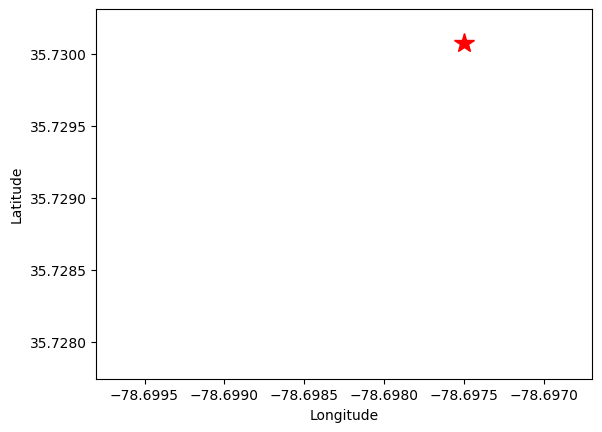

In [8]:
plt.plot(true_lon, true_lat, 'r*', markersize=15);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.xlim((BOUND_NW['lon'], BOUND_NE['lon']))  ;
plt.ylim((BOUND_SE['lat'], BOUND_NE['lat']))  ;
plt.ticklabel_format(useOffset=False) ;

Let's say that the observed data (the received signal strength) anywhere in this region is generated by the following function. Of course, we don't *know* this function - we can only observe samples from this function.

In [9]:
noise = 1

def black_box_function(lat, lon):
  distance = 1e3*np.sqrt((lat - true_lat)**2 + (lon - true_lon)**2)
  received_signal_strength_dbm  =  - 20 * np.log10(distance + 0.00001) + 35
  return np.clip(received_signal_strength_dbm, -20, 45) + np.random.normal(0, noise)

If we could fly our UAV around the search space for a few days, constantly sampling received signal strenght, we'd see something like this:

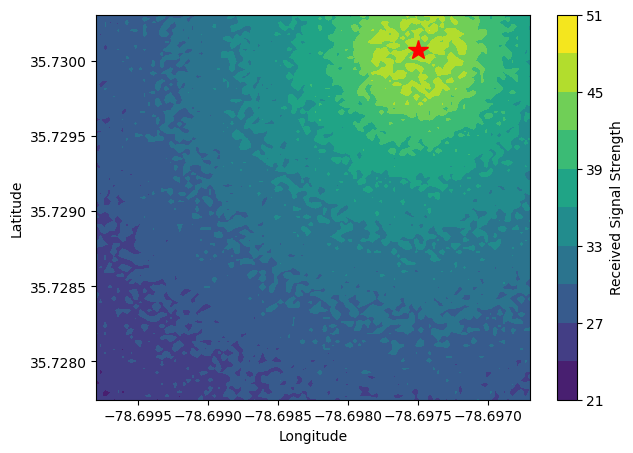

In [10]:
lat_grid = np.linspace(BOUND_SE['lat'], BOUND_NE['lat'], 100)
lon_grid = np.linspace(BOUND_SE['lon'], BOUND_SW['lon'], 100)

samples = np.zeros((len(lat_grid), len(lon_grid)))
for i, lat in enumerate(lat_grid):
    for j, lon in enumerate(lon_grid):
        samples[i, j] = black_box_function(lat, lon)

plt.figure(figsize=(7, 5))
plt.contourf(lon_grid, lat_grid, samples, cmap='viridis', vmin=20, vmax=50, levels=8)
plt.colorbar(label='Received Signal Strength')

plt.plot(true_lon, true_lat, 'r*', markersize=15);
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.xlim((BOUND_NW['lon'], BOUND_NE['lon']))  ;
plt.ylim((BOUND_SE['lat'], BOUND_NE['lat']))  ;
plt.ticklabel_format(useOffset=False) ;

But, let's see if we can find our hikers (the red star) without flying around for a few days.

### Set up model and optimizer

First, we will define:

* the *utility* function or *acquisition* function that the optimization will use, to decide which point to sample next. We will use an "upper confidence bound" function, which is a weighted sum of the mean of the Gaussian Process Regression ($\mu(x)$) and its uncertainty ($\sigma(x)$); the $\kappa$ value determines the tradeoff between sampling values of $x$ where we expect $x$ to be large, and sampling values of $x$ about which we are uncertain.

$$ \mu(x) + \kappa \sigma (x)$$

* the *kernel* that we will use for the Gaussian Process Regression. We will use the familiar RBF kernel, and we will specify that the length scale hyperparameter (which controls how wide or how narrow the curve is) should be in a particular range. Our optimizer will try a few different values in that range, to find the best one.

In [11]:
utility = acquisition.UpperConfidenceBound()
kernel = RBF(length_scale_bounds = (1e-04, 1e2))

Now we will define a Bayesian optimizer, and set up the kernel in the Gassian Process Regression.

In [12]:
optimizer = BayesianOptimization(
  f=None,
  pbounds={'lat': (BOUND_SE['lat'], BOUND_NE['lat']), 'lon': (BOUND_SW['lon'], BOUND_SE['lon'])},
  verbose=0,
  random_state=50,
  allow_duplicate_points=True,
  acquisition_function = utility
)
optimizer._gp.set_params(kernel = kernel)

GaussianProcessRegressor(alpha=1e-06, kernel=RBF(length_scale=1),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=RandomState(MT19937) at 0x7AC179109540)

Here are the initial kernel hyperparameters:

In [13]:
optimizer._gp.kernel.get_params()['length_scale']

1.0

Note that our `GaussianProcessRegressor` has `n_restarts_optimizer = 5`. This determines how many different values of the kernel hyperparameter will be considered each time we update the model.

We will set up some plotting functions to help us visualize the model -

In [15]:
def vis_optimizer():
  lat_grid = np.linspace(BOUND_SE['lat'], BOUND_NE['lat'], 100)
  lon_grid = np.linspace(BOUND_SE['lon'], BOUND_SW['lon'], 100)

  coord_grid  = np.meshgrid(lat_grid, lon_grid)
  coord_array = np.column_stack([coord_grid[0].ravel(), coord_grid[1].ravel()])

  predictions = optimizer._gp.predict(coord_array, return_std=True)
  gpr_mean = predictions[0].reshape(100, 100)
  gpr_var  = predictions[1].reshape(100, 100)

  lat_array = coord_array[:,0].reshape(100, 100)
  lon_array = coord_array[:,1].reshape(100, 100)

  try:
    y_max = optimizer._space.target.max()
  except:
    y_max = 0

  fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 8));

  axes[0, 0].contourf(lon_array, lat_array, gpr_mean, cmap='viridis', vmin=20, vmax=50, levels=8);
  axes[0, 0].set_title("Mean of predicted received signal strength");

  axes[0, 1].contourf(lon_grid, lat_grid, samples, cmap='viridis', vmin=20, vmax=50, levels=8);
  axes[0, 1].set_title("Actual function");
  try:
    for i, x_train in enumerate(optimizer._gp.X_train_):
      axes[0, 1].text(x_train[1], x_train[0], str(i), color="white", fontsize=8, fontweight='heavy', ha="center", va="center",
             bbox = dict(boxstyle=f"circle", fc="black"))
  except AttributeError:
    pass

  axes[1, 0].contourf(lon_array, lat_array, gpr_var, cmap='viridis');
  axes[1, 0].set_title("Variance of predicted received signal strength");

  try:
    util  = utility._get_acq(gp=optimizer._gp)(coord_array).reshape(100, 100)
    axes[1, 1].contourf(lon_array, lat_array, util, cmap='viridis_r', vmin=-50, vmax=-20, levels=8);
  except AttributeError:
    pass
  try:
      axes[1, 1].plot(next_point_to_probe['lon'], next_point_to_probe['lat'], marker='P', markersize=10, markerfacecolor='red', markeredgecolor='white');
  except NameError:
    pass
  axes[1, 1].set_title("Value of utility function");

  try:
    for i, x_train in enumerate(optimizer._gp.X_train_):
      axes[0, 0].plot(x_train[1], x_train[0], marker='P', markersize=10, markerfacecolor='black', markeredgecolor='white');
      axes[1, 0].plot(x_train[1], x_train[0], marker='P', markersize=10, markerfacecolor='black', markeredgecolor='white');
      axes[1, 1].plot(x_train[1], x_train[0], marker='P', markersize=10, markerfacecolor='black', markeredgecolor='white');
  except AttributeError:
    pass

  axes[0, 0].plot(true_lon, true_lat, marker='*', color='red', markersize=15)
  axes[0, 1].plot(true_lon, true_lat, marker='*', color='red', markersize=15)
  axes[1, 0].plot(true_lon, true_lat, marker='*', color='red', markersize=15)
  axes[1, 1].plot(true_lon, true_lat, marker='*', color='red', markersize=15)

  try:
      n_samples = optimizer._gp.X_train_.shape[0]
  except AttributeError:
      n_samples = 0

  true_pos = (true_lat, true_lon)
  est_pos  = (coord_array[np.argmax(gpr_mean)][0], coord_array[np.argmax(gpr_mean)][1])
  est_error = geopy.distance.geodesic(true_pos, est_pos).m
  plt.suptitle("Optimizer state after %d samples, error: %f m" % (n_samples, est_error));

  axes[0, 0].plot(est_pos[1], est_pos[0], marker='X', markersize=15, markerfacecolor='black', markeredgecolor='white');

  plt.ticklabel_format(useOffset=False) ;
  plt.tight_layout();


In [16]:
def plot_3D(elev=20, azim=-70):

  lat_grid = np.linspace(BOUND_SE['lat'], BOUND_NE['lat'], 100)
  lon_grid = np.linspace(BOUND_SE['lon'], BOUND_SW['lon'], 100)

  coord_grid  = np.meshgrid(lat_grid, lon_grid)
  coord_array = np.column_stack([coord_grid[0].ravel(), coord_grid[1].ravel()])

  predictions = optimizer._gp.predict(coord_array, return_std=True)
  gpr_mean = predictions[0].reshape(100, 100)
  gpr_var  = predictions[1].reshape(100, 100)

  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(projection = '3d')

  lat_array = coord_array[:,0].reshape(100, 100)
  lon_array = coord_array[:,1].reshape(100, 100)

  ax.plot_wireframe(lon_array, lat_array, gpr_mean, color='black', alpha=0.3)
  ax.plot_surface(lon_array, lat_array, gpr_mean, cmap=cm.viridis, alpha=0.7)

  y = optimizer._gp.y_train_*optimizer._gp._y_train_std + optimizer._gp._y_train_mean
  ax.scatter3D(optimizer._gp.X_train_[:,1], optimizer._gp.X_train_[:,0], y, c=y, edgecolor='black', s=50);

  ax.ticklabel_format(useOffset=False)
  ax.set_xlabel("Longitude")
  ax.set_ylabel("Latitude")
  ax.set_zlabel("Received Signal Strength")

  ax.view_init(elev=elev, azim=azim)
  plt.show()


then we can use that to see what our optimizer initially "knows" about the space that it is searching - nothing! But, as we begin to gather data, the model will start to improve its predictions.

In the following plot:

* the title tells us the current error of our model: how far is its estimate of the hikers' position from the true position?
* in each panel, the true position of the hikers is indicated with a red star
* the "Actual function" panel shows us samples of received signal strength from the "true" function over the search space. Since we are using synthetic data generated by us, we can get a value for each position in the search space and plot it.
* the "Mean of predicted received signal strength" panel shows us what the Gaussian Process Regression model predicts for the expected signal strength at each position in the search space. For now, since the model has not seen any training samples, its prediction is 0 everywhere.
* the "Variance of predicted received signal strength" panel shows us the variance in the model's estimate of the received signal strength at each position in the search space. For now, since the model has not seen any training samples, the variance is constant everywhere.
* the "Value of utility function" panel shows us where the model thinks it should sample the search space, in order to find the maximum value. For now, since the model has not seen any training samples, we do not have any information about where to search.

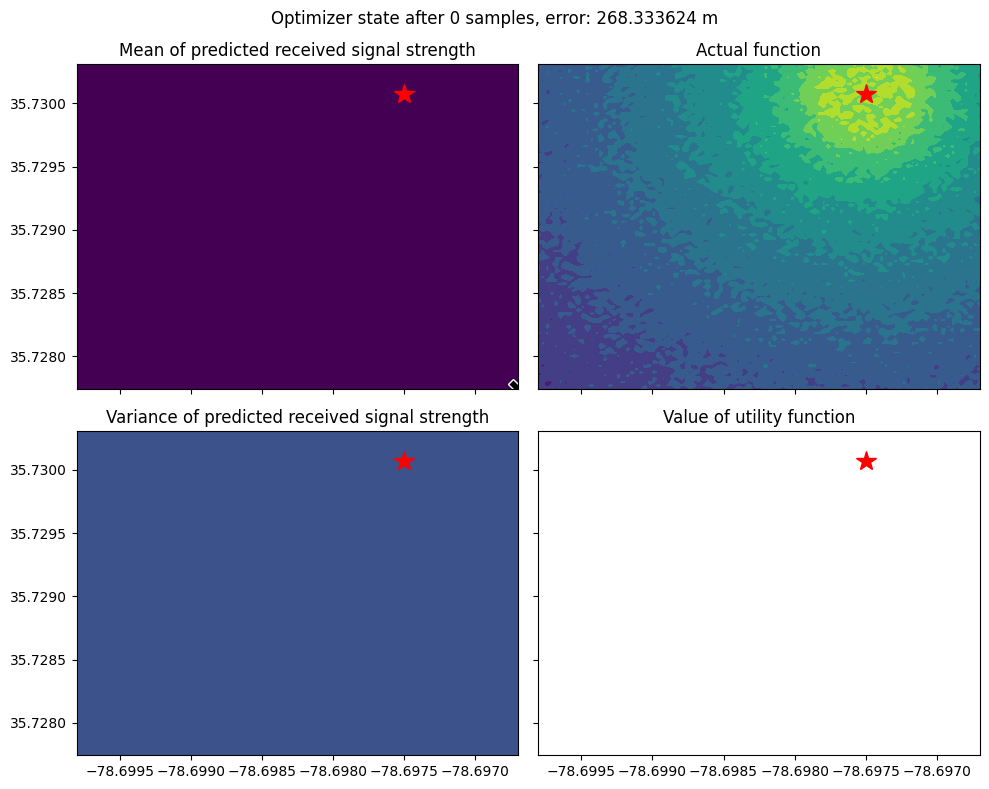

In [17]:
vis_optimizer()

### First search iteration

We are ready to start our search for the hikers! First, we will ask the optimizer to suggest a point to sample (using the utility function):

In [18]:
next_point_to_probe = optimizer.suggest()
next_point_to_probe

{'lat': 35.729012624150876, 'lon': -78.69909417570707}

The point suggested by the utility function will be indicated with a red `+` sign:

In [ ]:
# plot true value (red star) and next point to probe (blue +)
plt.plot(true_lon, true_lat, 'r*', markersize=15);
plt.plot(next_point_to_probe['lon'], next_point_to_probe['lat'], 'rP', markersize=15);
plt.xlim((BOUND_NW['lon'], BOUND_NE['lon']))  ;
plt.ylim((BOUND_SE['lat'], BOUND_NE['lat']))  ;

plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.ticklabel_format(useOffset=False) ;

Suppose we fly the UAV to that point, and measure $y$, the received signal strength:

In [ ]:
y = black_box_function(next_point_to_probe['lat'], next_point_to_probe['lon'])
y

We tell the optimizer what we observed at that point:

In [ ]:
optimizer.register(
    params=next_point_to_probe,
    target=y
)

and get the next point to probe:

In [ ]:
next_point_to_probe = optimizer.suggest()
next_point_to_probe


Let's now visualize the model state again - in the following plot:

* we can see in the title whether or not the error of our model estimate has improved.
* in the "Actual" function panel, we are also showing each point that we sampled - each training sample! - and the order in which we sampled them, using black circles. In the other panels, we show the sampled points using black '+' signs.
* the "Mean of predicted received signal strength" panel will still show a constant value everywhere, but that value has changed - now, we predict the value that we just observed for every point in the search space.
* the "Variance of predicted received signal strength" panel has changed! Our model is now more confident in its estimate of the received signal strength near the first sample. The variance of the predicted received signal strength is smallest near the sample it took, and increases as it gets farther from that location.
* the "Value of utility function" panel shows us where the model thinks it should sample the search space, in order to find the maximum value.

In [ ]:
vis_optimizer()

We can also represent this in 3D, with the height showing the received signal strength.

* the training samples are indicated as points
* the prediction of the model is shown as a wireframe/surface

This makes it clear that the model predicts the received signal strength from the first sample everywhere in the search space.


In [ ]:
interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=-70));


The GPR kernel parameters can change as the model is fitted. Let's check on them for now -

In [ ]:
optimizer._gp.kernel_.get_params()['length_scale']

### More search iterations

Let's do it again! We repeat the process of: visit the next point, tell the optimizer what we measured there, and get the next point to visit.

In [ ]:
y = black_box_function(next_point_to_probe['lat'], next_point_to_probe['lon'])
optimizer.register(
    params=next_point_to_probe,
    target=y
)
next_point_to_probe = optimizer.suggest()
print(y)

Now we know about the received signal strength at two locations that we have sampled - the variance is lowest there. We are also starting to see that the mean prediction and the value of the utility function is no longer constant across the search space, since we had two different measurements at different points.

The black 'X' in the first panel shows our estimate of the hikers' location - based on the observations we have so far collected, where does our model predict that signal strength will be highest? (This is the maximum of the mean of the Gaussian Process Regression.)

In [ ]:
vis_optimizer()

In our 3D visualization, we start to see the effect of the RBF kernel.

Our current kernel hyperparameters (small $l$) say that

* when very close to a training sample, the predicted signal strength should be similar to the value of the training sample,
* but that the effect falls off very quickly.

We will see how this changes as the optimizer gets new observations.

In [ ]:
optimizer._gp.kernel_.get_params()['length_scale']

In [ ]:
interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=-70));


Do it a third time -

In [ ]:
y = black_box_function(next_point_to_probe['lat'], next_point_to_probe['lon'])
optimizer.register(
    params=next_point_to_probe,
    target=y
)
next_point_to_probe = optimizer.suggest()
print(y)

Note that the black 'X' in the first panel is our model's current estimate of the position where the signal strength is highest - this is our estimate of the hikers' position.

In just a few steps, we have found a pretty good estimate. We can see this reflected in the title of the plot, which shows the distance between our estimate and the true position.

In [ ]:
vis_optimizer()

Depending on the data that is observed, the `length_scale` argument of the RBF kernel that is estimated to best fit the data may become larger, so the function learned by the model is smoother. We will be able to see this in the 3D plot, when it occurs.

In [ ]:
optimizer._gp.kernel_.get_params()['length_scale']

In [ ]:
interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=-70));


Let's iterate a fourth time -

In [ ]:
y = black_box_function(next_point_to_probe['lat'], next_point_to_probe['lon'])
optimizer.register(
    params=next_point_to_probe,
    target=y
)
next_point_to_probe = optimizer.suggest()
print(y)

In [ ]:
vis_optimizer()

In [ ]:
optimizer._gp.kernel_.get_params()['length_scale']

In [ ]:
interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=-70));


Let's repeat the process a few times, and visualize the result again -

In [ ]:
for _ in range(5):
    next_point_to_probe = optimizer.suggest()
    y = black_box_function(next_point_to_probe['lat'], next_point_to_probe['lon'])
    print(next_point_to_probe['lat'], next_point_to_probe['lon'], y)
    optimizer.register(params=next_point_to_probe, target=y)


In [ ]:
vis_optimizer()

You can see that the optimizer sometimes visits parts of the search space where it has seen high signal strength, and sometimes visits unexplored parts of the search space (to make sure it is not missing a larger maximum in another area.)

In [ ]:
optimizer._gp.kernel_.get_params()['length_scale']

In [ ]:
interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=-70));


We'll do it a few more times -

In [ ]:
for _ in range(5):
    next_point_to_probe = optimizer.suggest()
    y = black_box_function(next_point_to_probe['lat'], next_point_to_probe['lon'])
    print(next_point_to_probe['lat'], next_point_to_probe['lon'], y)
    optimizer.register(params=next_point_to_probe, target=y)


In [ ]:
vis_optimizer()

In [ ]:
optimizer._gp.kernel_.get_params()['length_scale']

In [ ]:
interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=-70));


After a while, our estimate of the hikers' position (and the error of the model) will start to stabliize. But because of the noise in the training samples, our prediction still has some error.

Furthermore, our Gaussian Process Regression may start to prefer a smaller `length_scale` hyperparameter and overfit to the noise in the training samples

In [ ]:
for _ in range(50):
    next_point_to_probe = optimizer.suggest()
    y = black_box_function(next_point_to_probe['lat'], next_point_to_probe['lon'])
    print(next_point_to_probe['lat'], next_point_to_probe['lon'], y)
    optimizer.register(params=next_point_to_probe, target=y)


In [ ]:
vis_optimizer()

In [ ]:
optimizer._gp.kernel_.get_params()['length_scale']

In [ ]:
interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=-70));
